# Project 2: Pauli channel

# Solution

In [ ]:
import numpy as np
from scipy.optimize import minimize, root

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# Tomography
from qiskit_experiments.library.tomography import StateTomography
from qiskit_experiments.framework import BatchExperiment
from qiskit.quantum_info import DensityMatrix

# Plots
import matplotlib.pyplot as plt

## Task 1
An example of a Pauli channel that can't be implemented with the circuit introduced in Project 1, is indeed the eternally non-Markovian channel that we are implementing in this project!

## Task 2

In [ ]:
def theta_from_p(p):
    # define our system of equations
    def fun(x,p):
        c1 = np.cos(x[0])
        c2 = np.cos(x[1])
        c3 = np.cos(x[2])
        s1 = np.sin(x[0])
        s2 = np.sin(x[1])
        s3 = np.sin(x[2])

        y1 = p[0] - (c1*c2*s3 - s1*s2*c3)**2
        y2 = p[1] - (c1*s2*c3 - s1*c2*s3)**2
        y3 = p[2] - (s1*c2*c3 + c1*s2*s3)**2
        return [y1, y2, y3]
    
    # find the roots of the system of equations
    # give random initial guess and low tolerance
    sol = root(fun, np.random.random(3)*2*np.pi, args=p, tol=1e-14)

    # alternatively, find the solution by minimizing the norm of the output of the function (when a solution is found the norm == 0.0)
    # give random initial guess, bounds and low tolerance 
    # sol = minimize(lambda x: np.linalg.norm(fun(x, p)), np.random.random(3)*2*np.pi, bounds=[(0.0,2*np.pi)]*3, method='L-BFGS-B', tol=1e-14)

    return sol.x


def pauli_channel(q, p, system, pauli_ancillae):
    """
        Apply the Pauli channel to system with probabilities p
        
    Args:
    q (QuantumRegister): the quantum register for the circuit
    system (int): index of the system qubit
    pauli_ancillae (list): list of indices of the ancillary qubits
    p (list): list of probabilities [p_1, p_2, p_3] for the Pauli channel
    
    Returns:
    A QuantumCircuit implementing the Pauli channel
    """
    
    angles = theta_from_p(p)
    theta_1 = angles[0]
    theta_2 = angles[1]
    theta_3 = angles[2]

    # quantum circuit
    pauli = QuantumCircuit(q)
    
    # apply appropriate gates to qubits
    a_0 = pauli_ancillae[0]
    a_1 = pauli_ancillae[1]

    pauli.ry(2*theta_1, q[a_0])
    pauli.cx(q[a_0], q[a_1])
    pauli.ry(2*theta_3, q[a_0])
    pauli.ry(2*theta_2, q[a_1])
    pauli.cx(q[a_0], q[system])
    pauli.cy(q[a_1], q[system])

    return pauli

## Task 3

By using the suggested imports, the functions `conditional_entropy` and `extractable_work` are actually
one-liners...

In [3]:
from qiskit.quantum_info import entropy, partial_trace

def conditional_entropy(state, qubit_a, qubit_b):
    """Conditional entropy S(A|B) = S(AB) - S(B)
    
    Args:
        state: a vector or density operator
        qubit_a: 0-based index of the qubit A
        qubit_b: 0-based index of the qubit B
        
    Returns:
        int: the conditional entropy
    """
    return entropy(state) - entropy(partial_trace(state, [qubit_b]))

def extractable_work(state, system_qubit, memory_qubit, n=1):
    """Extractable work from a two-qubit state
    =
    Cfr. Eq. (3-4) Bylicka et al., Sci. Rep. 6, 27989 (2016)
    
    Args:
        state: a vector or density operator
        system_qubit: index of the system qubit
        memory_qubit: index of the memory qubit
        n: number of system qubits
    """
    return (n - conditional_entropy(state, system_qubit, memory_qubit))

## Task 4
First of all, we define the function returning the probabilities as function of time:

In [4]:
def p_enm(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t * eta)), 
         1/4 * (1 - np.exp(-2 * t * eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 * np.exp(-t *eta) * np.cosh(t * omega))]
    return p

def p_ncp(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t * eta)), 
         1/4 * (1 - np.exp(-2 * t * eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 * np.exp(-t *eta) * np.cos(t * omega))]
    return p

In [5]:
# Here are the parameters
t_values = np.linspace(0, 3, 11)

# Parameters
params_ncp = {'eta': 0.1, 'omega': 2.0}
params_enm = {'eta': 1.0, 'omega': .5}

# And the qubit assignments
q = QuantumRegister(4, name='q')
c = ClassicalRegister(2, name='c')

system = 2
ancilla = 3

pauli_ancillae = [0, 1]

The state preparation circuit

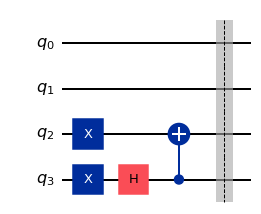

In [6]:
# Prepare the two qubits 0 and 2 in a psi- state
prepare_two_qubit = QuantumCircuit(q)

prepare_two_qubit.x(q[ancilla])
prepare_two_qubit.x(q[system])
prepare_two_qubit.h(q[ancilla])
prepare_two_qubit.cx(q[ancilla], q[system]) 
prepare_two_qubit.barrier()
prepare_two_qubit.draw('mpl')

And finally the simulation of the Pauli channel

Text(0, 0.5, '$W_{ex}/kT\\ln{2}$')

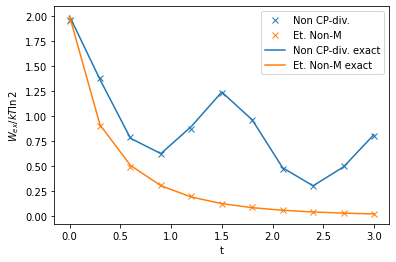

In [7]:
experiments = []
exact_results_ncp = []
exact_results_enm = []

for t in t_values:
    circ = prepare_two_qubit.compose(pauli_channel(q, p_ncp(t, **params_ncp), system, pauli_ancillae))
    tomo_fitter = StateTomography(circ, measurement_indices=[ancilla, system])
    experiments.append(tomo_fitter)
    exact_results_ncp.append(extractable_work(partial_trace(DensityMatrix(circ), pauli_ancillae).data, 1, 0))

for t in t_values:
    circ = prepare_two_qubit.compose(pauli_channel(q, p_enm(t, **params_enm), system, pauli_ancillae))
    tomo_fitter = StateTomography(circ, measurement_indices=[ancilla, system])
    experiments.append(tomo_fitter)
    exact_results_enm.append(extractable_work(partial_trace(DensityMatrix(circ), pauli_ancillae).data, 1, 0))

batch_exp = BatchExperiment(experiments, backend=AerSimulator())
job = batch_exp.run(shots=8192).block_for_results()

wext_ncp = []
wext_enm = []

for res in job.child_data()[:len(t_values)]:
    rho = res.analysis_results('state').value
    wext_ncp.append(extractable_work(rho, 1, 0))

for res in job.child_data()[len(t_values):]:
    rho = res.analysis_results('state').value
    wext_enm.append(extractable_work(rho, 1, 0))

plt.plot(t_values, wext_ncp, 'x', color='tab:blue', label='Non CP-div.')
plt.plot(t_values, wext_enm, 'x', color='tab:orange', label='Et. Non-M')
plt.plot(t_values, exact_results_ncp, color='tab:blue', label='Non CP-div. exact')
plt.plot(t_values, exact_results_enm, color='tab:orange', label='Et. Non-M exact')

plt.legend()
plt.xlabel('t')
plt.ylabel('$W_{ex}/kT\ln{2}$')